In [1]:
import pandas as pd
from Bio import GenBank
from Bio import SeqIO

In [2]:
genbank = '../20z_genome_files/20z.gb'
counts = './update_raw_counts.xlsx'
gb_record = SeqIO.read(genbank, "genbank")
counts_df = pd.read_excel(counts)

In [3]:
def index_genbank_features(gb_record, feature_type, qualifier) :
    answer = dict()
    for (index, feature) in enumerate(gb_record.features) :
        if feature.type==feature_type :
            if qualifier in feature.qualifiers :
                #There should only be one locus_tag per feature, but there
                #are usually several db_xref entries
                for value in feature.qualifiers[qualifier] :
                    if value in answer :
                        print("WARNING - Duplicate key %s for %s features %i and %i" \
                           % (value, feature_type, answer[value], index))
                    else :
                        answer[value] = index
    return answer

In [4]:
half1_flow = 0
half2_flow = 0
half1_len = 0
half2_len = 0
half_flag = False
for (index, feature) in enumerate(gb_record.features):
    if feature.type == 'CDS':
        dir_str = feature.location
        if feature.qualifiers['locus_tag'][0] == 'MEALZ_2017':
            half_flag = True
            
        if not half_flag:
            half1_len += 1
            if '+' in str(dir_str):
                half1_flow+=1
        if half_flag:
            half2_len += 1
            if '-' in str(dir_str):
                half2_flow+=1
    

In [5]:
half1_flow_prop = half1_flow/half1_len
half2_flow_prop = half2_flow/half2_len

In [6]:
import matplotlib.pyplot as plt
import numpy as np

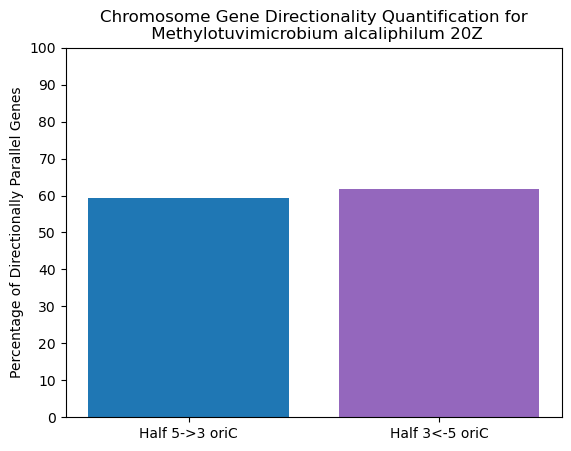

In [8]:
fig, ax = plt.subplots()

dna = ['Half 5->3 oriC', 'Half 3<-5 oriC']
proporitions = [half1_flow_prop*100, half2_flow_prop*100]
bar_labels = ['Half 5->3', 'Half 3<-5']
colors = ['tab:blue', 'tab:purple']

ax.bar(dna, proporitions, label=bar_labels, color=colors)

ax.set_ylabel('Percentage of Directionally Parallel Genes')
ax.set_title("Chromosome Gene Directionality Quantification for\n Methylotuvimicrobium alcaliphilum 20Z")
ax.set_yticks(np.arange(0,110,10))

plt.show()
fig.savefig('Gene Directionality Figure 20Z.png')
plt.close()

In [9]:
mealz_cds_index = index_genbank_features(gb_record,"CDS","locus_tag")
counts_df['Meoh'] = counts_df[['Meoh1', 'Meoh2']].mean(axis=1)
counts_df['Meoh +Cu'] = counts_df[['Meoh +Cu1', 'Meoh +Cu2']].mean(axis=1)

half_flag = False

expression_dict = {'Half oriC 5->3': {'With': {'Copper':0, '- Copper':0}, 'Against':{'Copper':0, '- Copper':0}}, 
                   'Half oriC 3<-5': {'With': {'Copper':0, '- Copper':0}, 'Against':{'Copper':0, '- Copper':0}}}

for idx,row in counts_df.iterrows():
    locus = row['Old Locus']
    if locus == 'MEALZ_2017':
        half_flag=True
    dir_str = str(gb_record.features[mealz_cds_index[locus]].location)
    
    if not half_flag:
        if '+' in dir_str:
            expression_dict['Half oriC 5->3']['With']['- Copper'] += row['Meoh']
            expression_dict['Half oriC 5->3']['With']['Copper'] += row['Meoh +Cu']
        else:
            expression_dict['Half oriC 5->3']['Against']['- Copper'] += row['Meoh']
            expression_dict['Half oriC 5->3']['Against']['Copper'] += row['Meoh +Cu']
    else:
        if '-' in dir_str:
            expression_dict['Half oriC 3<-5']['With']['- Copper'] += row['Meoh']
            expression_dict['Half oriC 3<-5']['With']['Copper'] += row['Meoh +Cu']
        else:
            expression_dict['Half oriC 3<-5']['Against']['- Copper'] += row['Meoh']
            expression_dict['Half oriC 3<-5']['Against']['Copper'] += row['Meoh +Cu']

print(expression_dict)

{'Half oriC 5->3': {'With': {'Copper': 508213.1130000007, '- Copper': 369776.56600000005}, 'Against': {'Copper': 159243.5370000001, '- Copper': 131769.6120000001}}, 'Half oriC 3<-5': {'With': {'Copper': 482300.3974999999, '- Copper': 271052.91949999984}, 'Against': {'Copper': 179565.95049999986, '- Copper': 149215.40749999997}}}


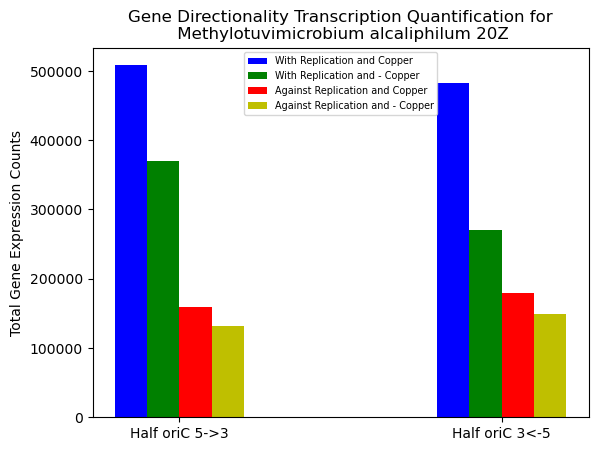

In [46]:
fig, ax = plt.subplots()

dna = np.arange(2)

with_and_copper = [expression_dict['Half oriC 5->3']['With']['Copper'], expression_dict['Half oriC 3<-5']['With']['Copper']]
with_and_nocopper = [expression_dict['Half oriC 5->3']['With']['- Copper'], expression_dict['Half oriC 3<-5']['With']['- Copper']]
against_and_copper = [expression_dict['Half oriC 5->3']['Against']['Copper'], expression_dict['Half oriC 3<-5']['Against']['Copper']]
against_and_nocopper = [expression_dict['Half oriC 5->3']['Against']['- Copper'], expression_dict['Half oriC 3<-5']['Against']['- Copper']]

ax.bar(dna-0.15, with_and_copper, width=0.1,color='b', align='center', label='With Replication and Copper')
ax.bar(dna-0.05, with_and_nocopper, width=0.1, color='g', align='center', label='With Replication and - Copper')
ax.bar(dna+0.05, against_and_copper, width=0.1, color='r', align='center', label='Against Replication and Copper')
ax.bar(dna+0.15, against_and_nocopper, width=0.1, color='y', align='center', label='Against Replication and - Copper')

ax.set_ylabel('Total Gene Expression Counts')
ax.set_title("Gene Directionality Transcription Quantification for\n Methylotuvimicrobium alcaliphilum 20Z")
ax.legend(loc='upper center', ncols=1, fontsize='x-small')
ax.set_xticks(np.arange(2))
ax.set_xticklabels(['Half oriC 5->3', 'Half oriC 3<-5'])

plt.show()
fig.savefig('Gene Transcription Directionality Figure 20Z.png')
plt.close()